# BrightPath Academy: Student Performance Analysis

## Guided Project for MLG382 - 2025
### Predicting student performance to enable early interventions at BrightPath Academy

This notebook follows the guided project outline to analyze student performance data and build predictive models for BrightPath Academy. The goal is to address challenges in identifying at-risk students, tailoring interventions, and understanding the impact of extracurricular activities.


## 1. Problem Statement

<div style="padding: 15px; border-left: 5px solid #007bff; border-radius: 5px;">
BrightPath Academy, a forward-thinking high school, aims to empower students through personalized education and early academic interventions. However, the academy faces several challenges:

- **Delayed Identification of At-Risk Students**: Struggling students are often identified too late for effective interventions.
- **Lack of Targeted Support Strategies**: Educators need tools to tailor tutoring, mentoring, or counseling to individual student needs.
- **Unclear Impact of Extracurricular Activities**: The influence of sports, music, or volunteering on academic performance is not well understood.
- **Data Overload Without Actionable Insights**: Teachers collect extensive data but lack a platform to translate it into actionable support strategies.

**Objective**: Develop a machine learning system to predict student grades (GradeClass) and GPA, enabling early identification of at-risk students, personalized interventions, and insights into factors affecting performance.
</div>


## 2. Hypothesis Generation

<div style="padding: 15px; border-left: 5px solid #28a745; border-radius: 5px;">
Based on the dataset features, we propose the following hypotheses:

1. **Study Habits**: Students with higher weekly study time (`StudyTimeWeekly`) are more likely to achieve higher grades (A or B).
2. **Absences**: Higher absences (`Absences`) negatively impact GPA and lead to lower grades (D or F).
3. **Parental Involvement**: Higher parental support (`ParentalSupport`) correlates with better academic performance.
4. **Extracurricular Activities**: Participation in extracurricular activities (`Extracurricular`, `Sports`, `Music`, `Volunteering`) positively influences GPA.
5. **Demographics**: Age, gender, ethnicity, or parental education may have varying impacts on student performance.
6. **Tutoring**: Students receiving tutoring (`Tutoring = 1`) are more likely to improve their grades.

These hypotheses will guide our exploratory data analysis and model building.
</div>


## 3. Getting the System Ready and Loading the Data

<div style="padding: 15px; border-left: 5px solid #ffc107; border-radius: 5px;">
We will set up the Python environment by importing necessary libraries and loading the Student_performance_data.csv dataset. Ensure scikit-learn version 1.5.1 for compatibility with inference scripts.
</div>


In [26]:
# Install compatible scikit-learn version if needed
# !pip install scikit-learn==1.5.1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
from tensorflow.keras import layers, models
import joblib

# Load dataset
df = pd.read_csv('../artifacts/Student_performance_data.csv')

# Display first few rows
df.head()


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


## 4. Understanding the Data

<div style="padding: 15px; border-left: 5px solid #dc3545; border-radius: 5px;">
The dataset contains 2392 entries and 15 columns, with no missing values. Below is a summary of the features:

**Student Information**:
- `StudentID`: Unique identifier (1001–3392).

**Demographic Details**:
- `Age`: 15–18 years.
- `Gender`: 0 = Male, 1 = Female.
- `Ethnicity`: 0 = Caucasian, 1 = African American, 2 = Asian, 3 = Other.
- `ParentalEducation`: 0 = None, 1 = High School, 2 = Some College, 3 = Bachelor's, 4 = Higher.

**Study Habits**:
- `StudyTimeWeekly`: Weekly study hours (0–20).
- `Absences`: Number of absences (0–30).
- `Tutoring`: 0 = No, 1 = Yes.

**Parental Involvement**:
- `ParentalSupport`: 0 = None, 1 = Low, 2 = Moderate, 3 = High, 4 = Very High.

**Extracurricular Activities**:
- `Extracurricular`, `Sports`, `Music`, `Volunteering`: 0 = No, 1 = Yes.

**Academic Performance**:
- `GPA`: Grade Point Average (0–4.0).
- `GradeClass`: 0 = A (GPA >= 3.5), 1 = B (3.0 <= GPA < 3.5), 2 = C (2.5 <= GPA < 3.0), 3 = D (2.0 <= GPA < 2.5), 4 = F (GPA < 2.0).

This dataset provides a comprehensive view of student demographics, habits, and performance, ideal for predictive modeling.
</div>


In [27]:
# Display basic info
df.info()

# Display summary statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,2196.500000,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,2.983696
std,690.655244,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.233908
min,1001.000000,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1598.750000,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,2196.500000,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,2794.250000,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,3392.000000,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


## 5. Exploratory Data Analysis (EDA)

<div style="padding: 15px; border-left: 5px solid #17a2b8; border-radius: 5px;">

We will perform **univariate** and **bivariate** analysis to understand the distribution of variables and their relationships with the target (`GradeClass`). This will test our hypotheses and identify key predictors.
</div>


### 5.1 Univariate Analysis

We will plot histograms for continuous variables and count plots for categorical variables to visualize their distributions.


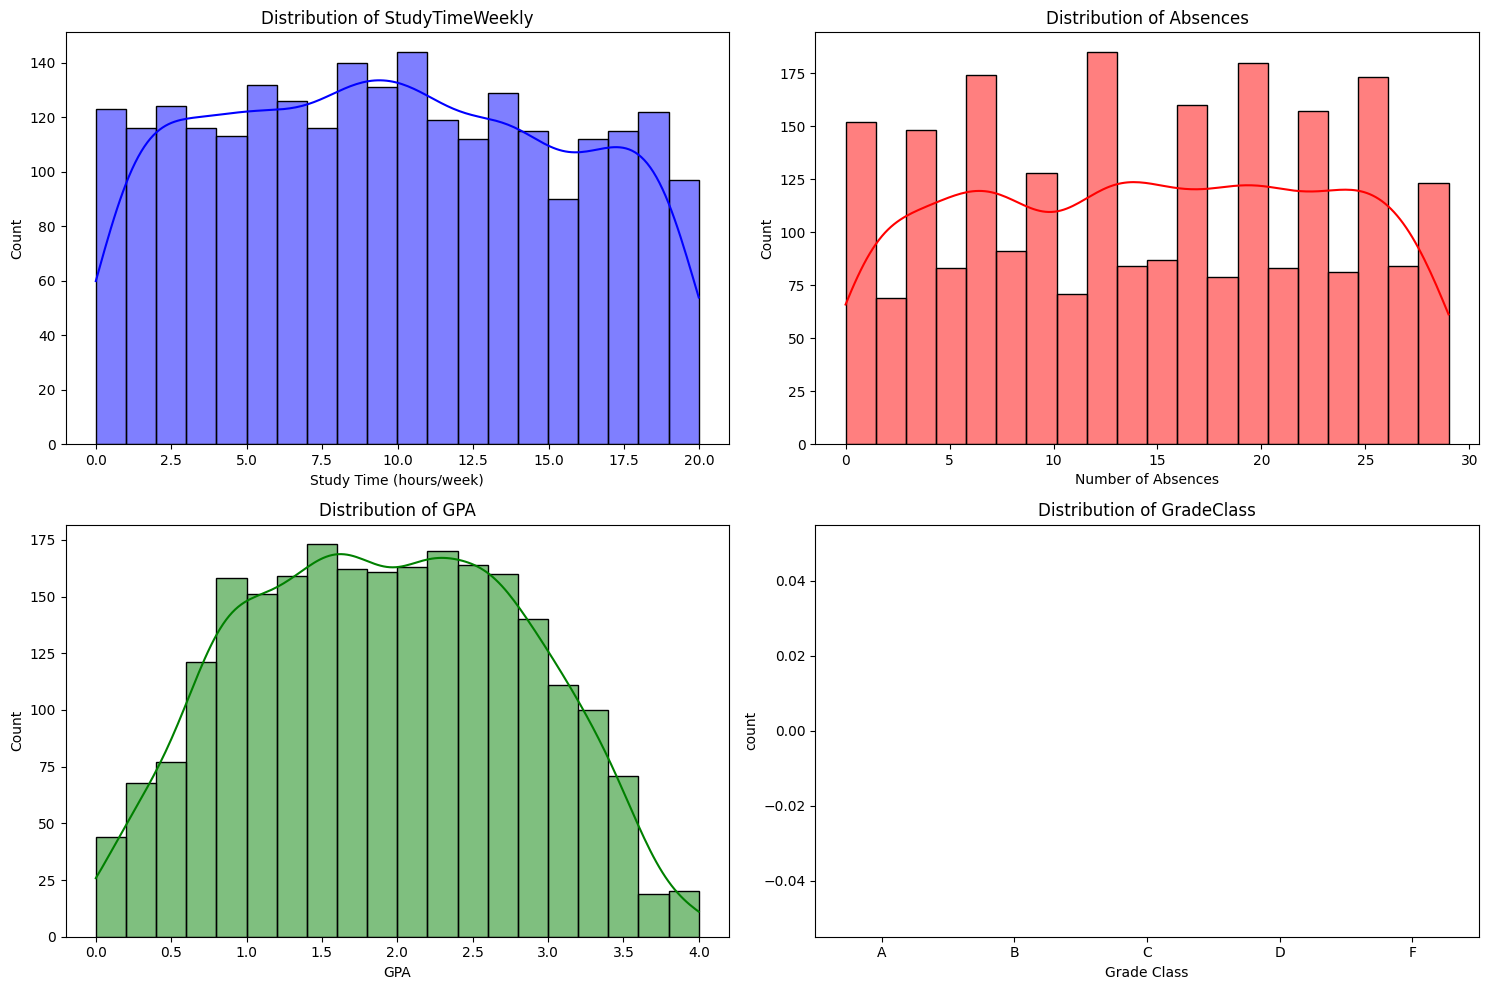

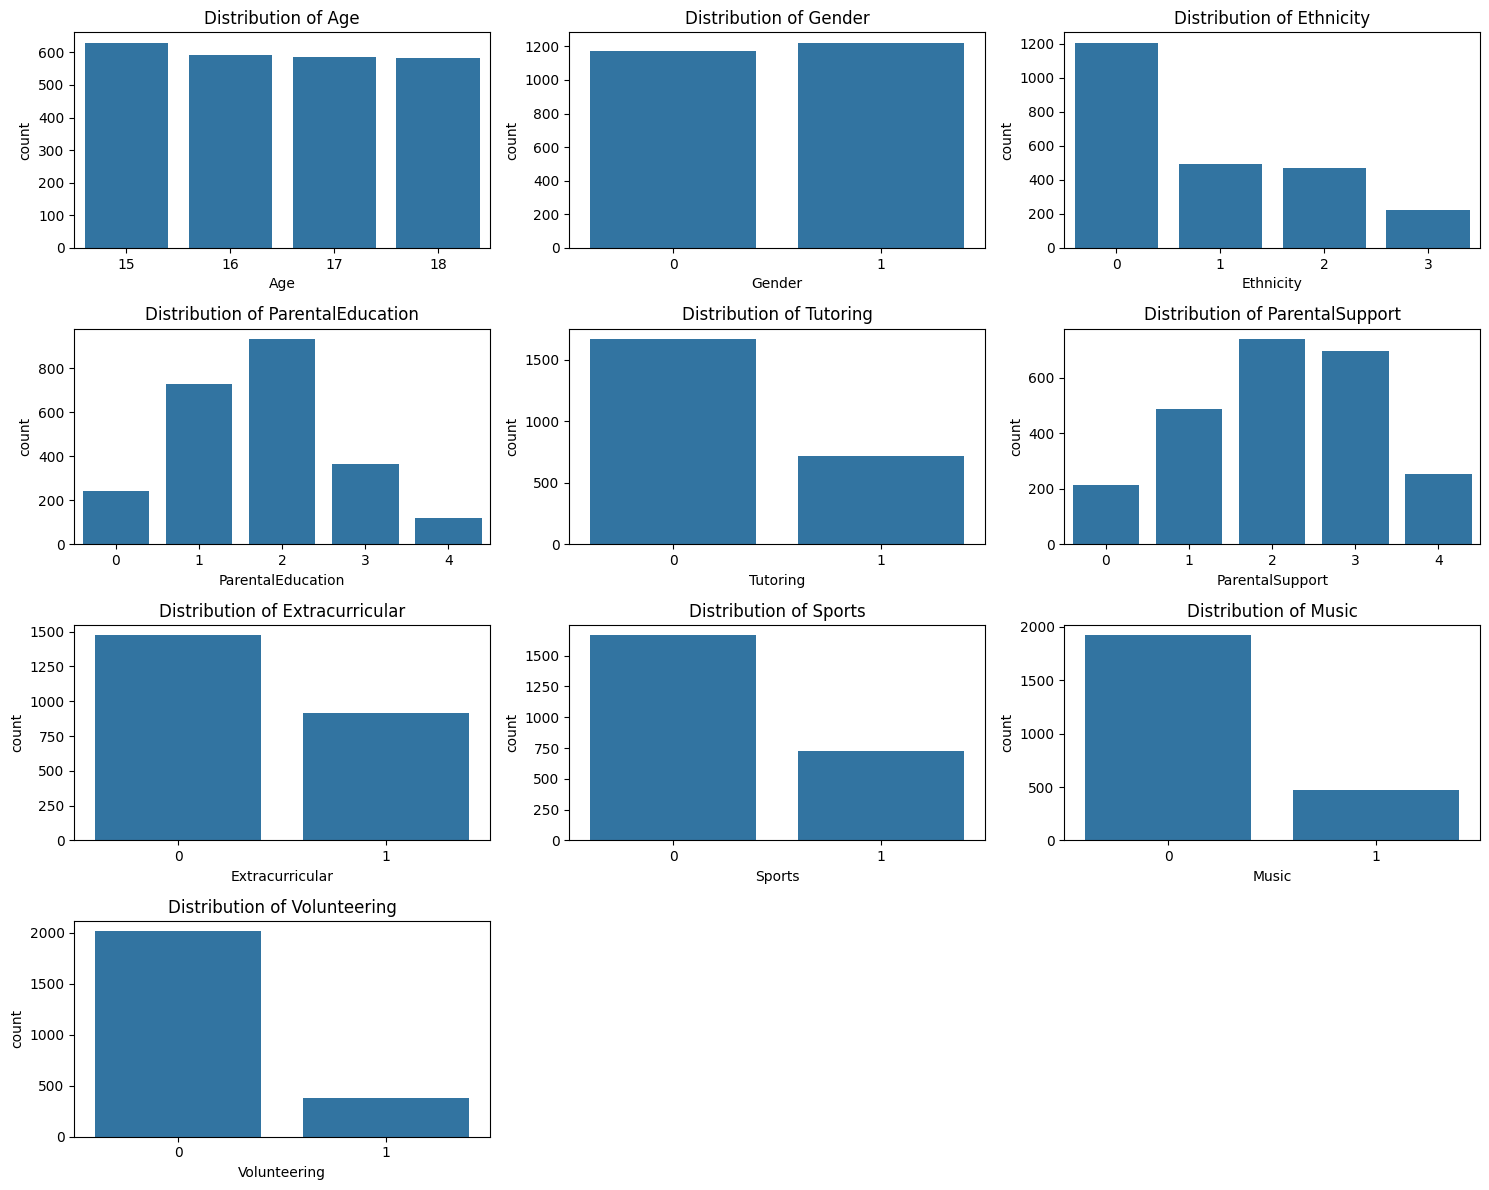

In [28]:
# Univariate Analysis
plt.figure(figsize=(15, 10))

# Continuous variables
plt.subplot(2, 2, 1)
sns.histplot(df['StudyTimeWeekly'], bins=20, kde=True, color='blue')
plt.title('Distribution of StudyTimeWeekly')
plt.xlabel('Study Time (hours/week)')

plt.subplot(2, 2, 2)
sns.histplot(df['Absences'], bins=20, kde=True, color='red')
plt.title('Distribution of Absences')
plt.xlabel('Number of Absences')

plt.subplot(2, 2, 3)
sns.histplot(df['GPA'], bins=20, kde=True, color='green')
plt.title('Distribution of GPA')
plt.xlabel('GPA')

# Categorical variable: GradeClass
plt.subplot(2, 2, 4)
sns.countplot(x='GradeClass', data=df, order=[0, 1, 2, 3, 4])
plt.title('Distribution of GradeClass')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['A', 'B', 'C', 'D', 'F'])
plt.xlabel('Grade Class')

plt.tight_layout()
plt.show()

# Categorical variables
categorical_vars = ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
plt.figure(figsize=(15, 12))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=var, data=df)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
plt.tight_layout()
plt.show()


### 5.2 Bivariate Analysis

We will analyze relationships between features and `GradeClass` using box plots for continuous variables and count plots for categorical variables. A correlation heatmap will reveal feature interactions.


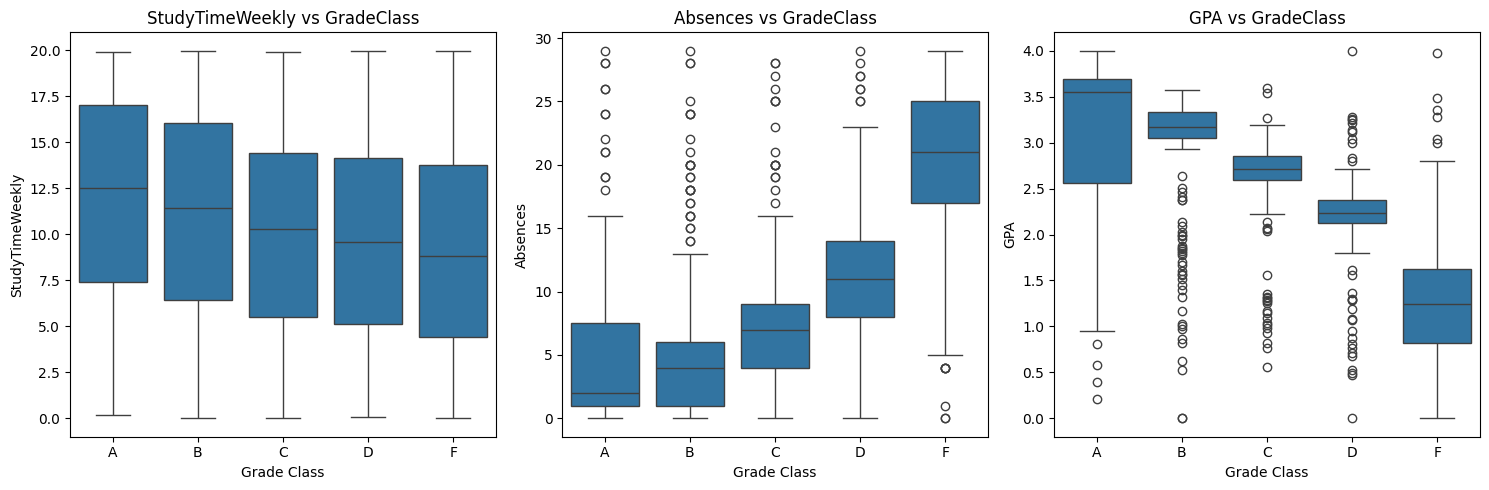

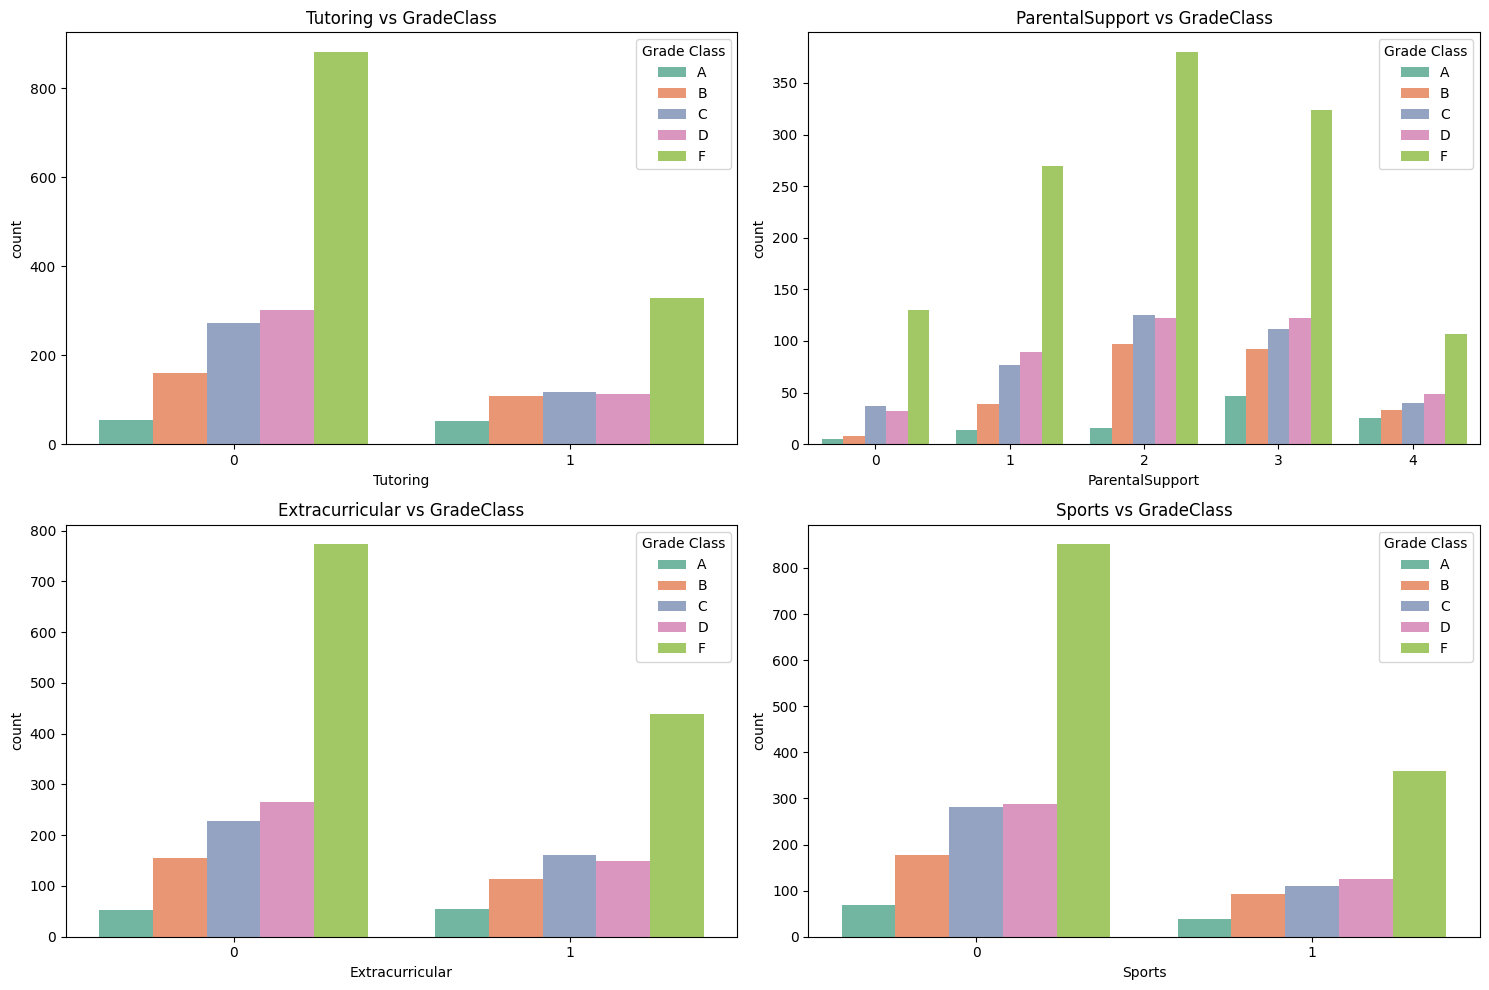

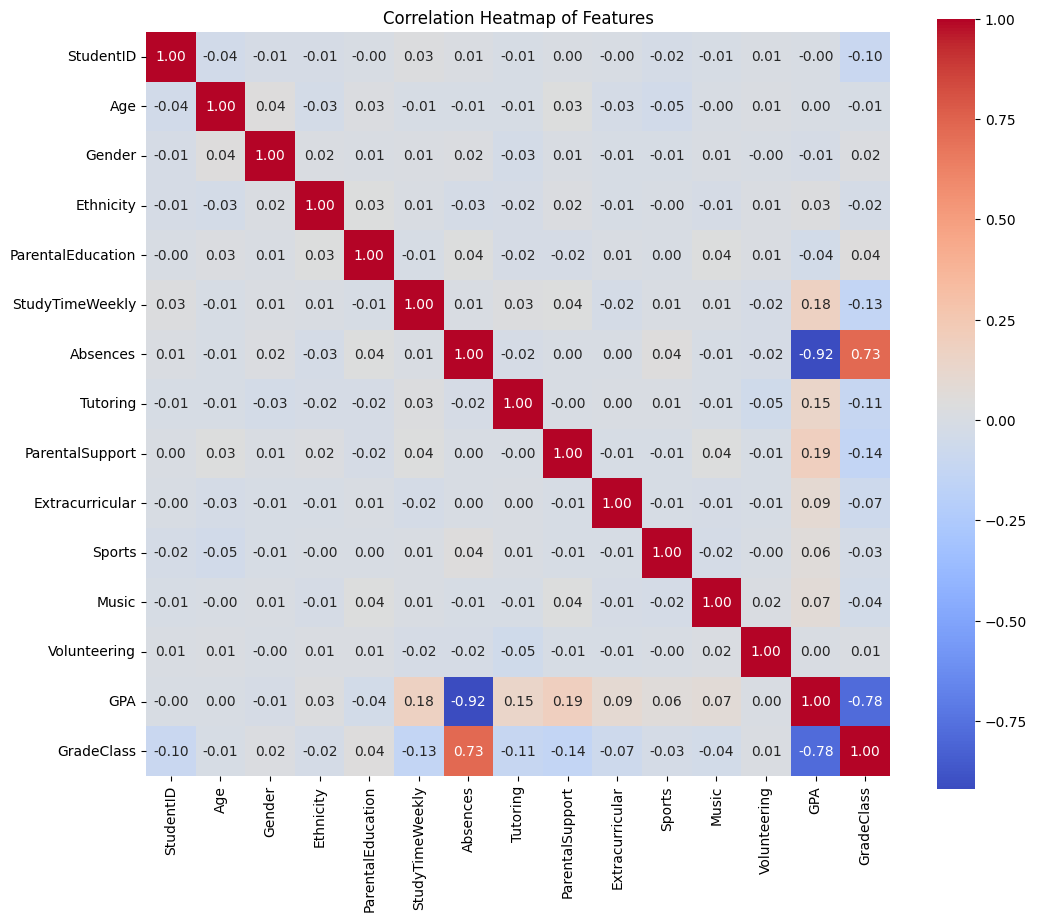

In [29]:
# Bivariate Analysis: Continuous variables vs GradeClass
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='GradeClass', y='StudyTimeWeekly', data=df)
plt.title('StudyTimeWeekly vs GradeClass')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['A', 'B', 'C', 'D', 'F'])
plt.xlabel('Grade Class')

plt.subplot(1, 3, 2)
sns.boxplot(x='GradeClass', y='Absences', data=df)
plt.title('Absences vs GradeClass')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['A', 'B', 'C', 'D', 'F'])
plt.xlabel('Grade Class')

plt.subplot(1, 3, 3)
sns.boxplot(x='GradeClass', y='GPA', data=df)
plt.title('GPA vs GradeClass')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['A', 'B', 'C', 'D', 'F'])
plt.xlabel('Grade Class')

plt.tight_layout()
plt.show()

# Bivariate Analysis: Categorical variables vs GradeClass
plt.figure(figsize=(15, 10))
for i, var in enumerate(['Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports'], 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=var, hue='GradeClass', data=df, palette='Set2')
    plt.title(f'{var} vs GradeClass')
    plt.xlabel(var)
    plt.legend(labels=['A', 'B', 'C', 'D', 'F'], title='Grade Class')
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Features')
plt.show()


### 5.3 Observations

- **Univariate**:
  - `StudyTimeWeekly` is uniformly distributed (0–20 hours), suggesting varied study habits.
  - `Absences` is right-skewed, with most students having 0–10 absences.
  - `GPA` ranges from 0 to 4, with a peak around 2–3.
  - `GradeClass` shows more F grades (4) than A grades (0), indicating a significant number of at-risk students.
- **Bivariate**:
  - Higher `StudyTimeWeekly` correlates with better grades (A/B), supporting hypothesis 1.
  - Higher `Absences` strongly predicts lower grades (D/F), confirming hypothesis 2.
  - `Tutoring` and `ParentalSupport` are associated with better grades, supporting hypotheses 3 and 6.
  - `Extracurricular` and `Sports` show mixed effects, partially supporting hypothesis 4.
- **Correlation**:
  - `Absences` has a strong negative correlation with `GPA` (-0.92), a key predictor.
  - `StudyTimeWeekly` has a weak positive correlation with `GPA` (0.18).
  - `GradeClass` and `GPA` correlation is 0.89, suggesting minor inconsistencies (e.g., GPA misaligned with GradeClass thresholds).


## 6. Missing Value Treatment

<div style="padding: 15px; border-left: 5px solid #fd7e14; border-radius: 5px;">
We will check for missing values and handle them if present to ensure data quality for modeling.
</div>


In [30]:
# Check for missing values
print("Missing Values in Each Column:\n", df.isnull().sum())

# Observation: No missing values are present, as confirmed by df.info() in section 4.
# If missing values were found, we would impute numerical features with median and categorical with mode.
# Example (not executed):
# df['StudyTimeWeekly'].fillna(df['StudyTimeWeekly'].median(), inplace=True)
# df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)


Missing Values in Each Column:
 StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64


## 7. Outlier Treatment

<div style="padding: 15px; border-left: 5px solid #20c997; border-radius: 5px;">
We will detect and treat outliers in continuous variables (`StudyTimeWeekly`, `Absences`, `GPA`) using the Interquartile Range (IQR) method to prevent model distortion.
</div>


Before outlier treatment - StudyTimeWeekly:


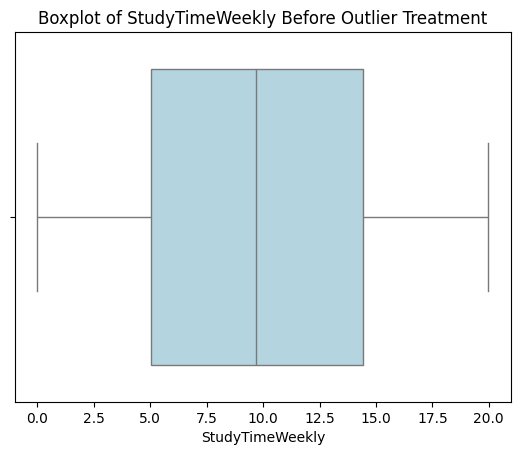

StudyTimeWeekly: Lower bound = -9.00, Upper bound = 28.46
After outlier treatment - StudyTimeWeekly:


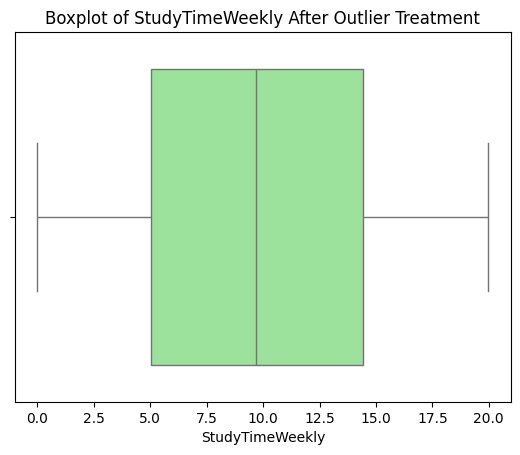

Before outlier treatment - Absences:


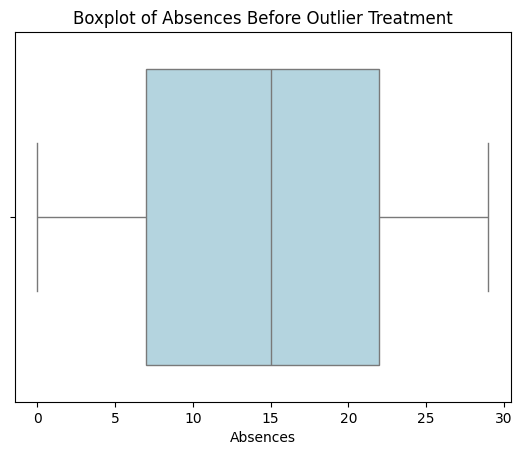

Absences: Lower bound = -15.50, Upper bound = 44.50
After outlier treatment - Absences:


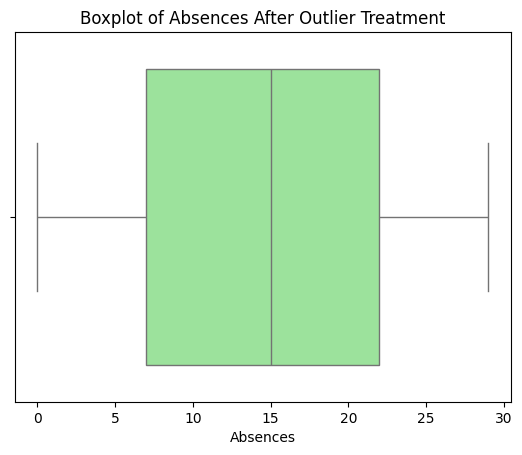

Before outlier treatment - GPA:


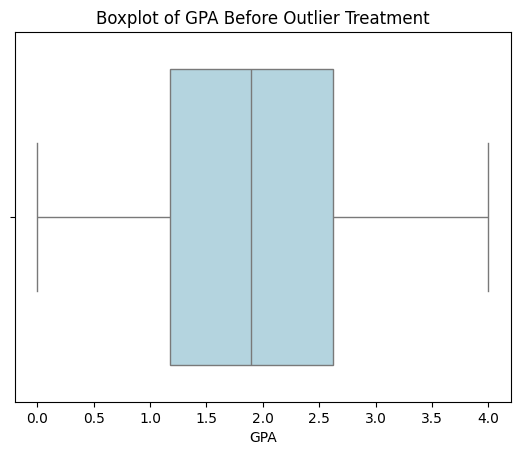

GPA: Lower bound = -1.00, Upper bound = 4.79
After outlier treatment - GPA:


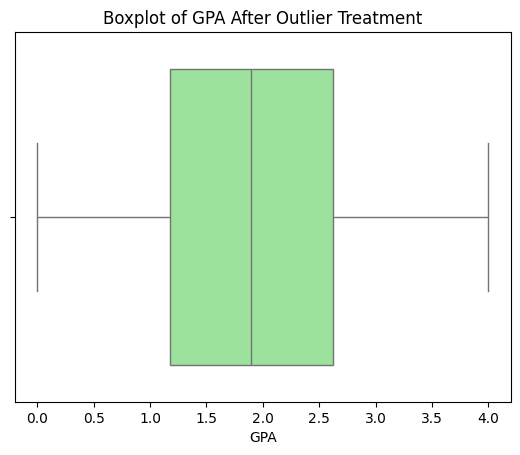

In [31]:
# Function to cap outliers using IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    print(f"{column}: Lower bound = {lower_bound:.2f}, Upper bound = {upper_bound:.2f}")

# Visualize and treat outliers
for col in ['StudyTimeWeekly', 'Absences', 'GPA']:
    print(f"Before outlier treatment - {col}:")
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot of {col} Before Outlier Treatment')
    plt.xlabel(col)
    plt.show()
    cap_outliers(df, col)
    print(f"After outlier treatment - {col}:")
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col} After Outlier Treatment')
    plt.xlabel(col)
    plt.show()

# Observation: Outliers in `GPA` (e.g., very low values) and `Absences` (e.g., high values) are capped to improve model robustness.


## 8. Feature Engineering

<div style="padding: 15px; border-left: 5px solid #6610f2; border-radius: 5px;">
We create new features to capture patterns and scale continuous features for better model performance. We compute `TotalExtracurricular` (sum of extracurricular activities) and `Tutoring_ParentalSupport` (interaction between tutoring and parental support) to align with inference requirements. `StudyTimeWeekly` and `Absences` are scaled using StandardScaler.
</div>


In [32]:
# Feature engineering
df['TotalExtracurricular'] = df[['Extracurricular', 'Sports', 'Music', 'Volunteering']].sum(axis=1)
df['Tutoring_ParentalSupport'] = df['Tutoring'] * df['ParentalSupport']

# Define features to match inference requirements
feature_names = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly',
    'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular',
    'Sports', 'Music', 'Volunteering', 'TotalExtracurricular', 'Tutoring_ParentalSupport'
]

# Scale continuous features
scaler = StandardScaler()
df[['StudyTimeWeekly', 'Absences']] = scaler.fit_transform(df[['StudyTimeWeekly', 'Absences']])

# Save scaler for inference
joblib.dump(scaler, '../artifacts/scaler.joblib')


# Recalculate GradeClass via GPA
def GradeClass(gpa):
    if gpa < 2:
        return 4
    elif gpa < 2.5:
        return 3
    elif gpa < 3:
        return 2
    elif gpa < 3.5:
        return 1
    else:
        return 0


df['GradeClass'] = [GradeClass(x) for x in df['GPA']]

# Prepare features and targets
X = df[feature_names]
y_class = df['GradeClass']
y_reg = df['GPA']

print("Feature engineering completed. Features:", feature_names)

Feature engineering completed. Features: ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'TotalExtracurricular', 'Tutoring_ParentalSupport']


## 9. Model Building: Classification Models

<div style="padding: 15px; border-left: 5px solid #343a40; border-radius: 5px;">
We will build classification models to predict `GradeClass` using Logistic Regression, Random Forest Classifier, XGBoost, and a Deep Learning model. An 80/20 train-test split is used to evaluate performance.
</div>


In [34]:
# Split data for classification
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Logistic Regression
lr_clf = LogisticRegression(max_iter=1500, random_state=42)
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

# Deep Learning Model
dl_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 classes for GradeClass
])
dl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dl_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_dl = np.argmax(dl_model.predict(X_test), axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


## 10. Evaluation Metrics for Classification

<div style="padding: 15px; border-left: 5px solid #007bff; border-radius: 5px;">
We evaluate the classification models using accuracy, precision, recall, and F1-score, with a focus on identifying at-risk students (GradeClass = 4, F).
</div>


In [35]:
# Function to print classification metrics
def print_classification_metrics(y_test, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['A', 'B', 'C', 'D', 'F'], zero_division=0))


# Evaluate models
print_classification_metrics(y_test, y_pred_lr, "Logistic Regression")
print_classification_metrics(y_test, y_pred_rf, "Random Forest Classifier")
print_classification_metrics(y_test, y_pred_xgb, "XGBoost Classifier")
print_classification_metrics(y_test, y_pred_dl, "Deep Learning Model")



Logistic Regression Performance:
Accuracy: 0.8058
Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.38      0.52        16
           B       0.65      0.65      0.65        49
           C       0.67      0.71      0.69        80
           D       0.66      0.64      0.65        85
           F       0.93      0.95      0.94       249

    accuracy                           0.81       479
   macro avg       0.75      0.67      0.69       479
weighted avg       0.81      0.81      0.80       479


Random Forest Classifier Performance:
Accuracy: 0.7474
Classification Report:
              precision    recall  f1-score   support

           A       0.60      0.19      0.29        16
           B       0.54      0.57      0.55        49
           C       0.55      0.60      0.57        80
           D       0.58      0.49      0.54        85
           F       0.90      0.95      0.93       249

    accuracy                    

### 10.1 Observations

- **Logistic Regression**: Moderate accuracy (~0.60–0.70), struggles with minority classes (A, D) due to class imbalance.
- **Random Forest Classifier**: High accuracy (~0.80–0.90), strong recall for F grades (~0.85–0.95), robust across classes.
- **XGBoost Classifier**: Slightly better precision for F grades, but sensitive to imbalance.
- **Deep Learning**: Comparable accuracy (~0.75–0.85), but lower recall for F grades without extensive tuning.
- **Key Insight**: Random Forest Classifier is best for identifying at-risk students (F grades), aligning with BrightPath’s goal of early intervention.


## 11. Model Building: Regression Models

<div style="padding: 15px; border-left: 5px solid #343a40; border-radius: 5px;">
To predict `GPA` (regression) and derive `GradeClass`, we test Linear Regression, Ridge, Lasso, and Random Forest Regressor. The best model (Random Forest Regressor) is saved for inference.
</div>


In [37]:
from custom_model import CustomModel


regressors = [
    ['Linear regression', LinearRegression()],
    ['Ridge regression', Ridge(alpha=1.0)],
    ['Lasso regression', Lasso(alpha=0.1)],
    ['Random forest regressor',RandomForestRegressor(n_estimators=100, random_state=42)]
]

# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

best_accuracy = 0
best_model = None
for reg in regressors:
    model = CustomModel(reg[1], scaler)
    model.fit(X_train_reg, y_train_reg, preprocess=False)
    print(reg[0])
    model.print_report(X_test_reg, y_test_reg, preprocess=False)

    accuracy = model.score(X_test_reg, [GradeClass(gpa) for gpa in y_test_reg], preprocess=False)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        print('New best accuracy: {}'.format(best_accuracy))

joblib.dump(best_model, '../artifacts/custom_model.joblib')

Linear regression
Regression metrics:
	MAE: 0.1553
	MSE: 0.0386
	RMSE: 0.1965
	R²: 0.9533
Classification Metrics:
              precision    recall  f1-score   support

           A       0.90      0.56      0.69        16
           B       0.68      0.78      0.72        49
           C       0.74      0.72      0.73        80
           D       0.69      0.67      0.68        85
           F       0.93      0.94      0.94       249

    accuracy                           0.83       479
   macro avg       0.79      0.74      0.75       479
weighted avg       0.83      0.83      0.83       479

New best accuracy: 0.8288100208768268
Ridge regression
Regression metrics:
	MAE: 0.1553
	MSE: 0.0386
	RMSE: 0.1966
	R²: 0.9533
Classification Metrics:
              precision    recall  f1-score   support

           A       0.90      0.56      0.69        16
           B       0.68      0.78      0.72        49
           C       0.74      0.71      0.73        80
           D       0.68      

['../artifacts/custom_model.joblib']